In [219]:
%config IPCompleter.greedy=True

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
from scipy import optimize
from scipy.special import expit
from random import sample
import random
import collections

In [2]:
data = scipy.io.loadmat("ex4data1.mat")
weights = scipy.io.loadmat("ex4weights.mat")

In [3]:
X = data['X']; y = data['y']
theta = [weights['Theta1'], weights['Theta2']]

In [4]:
print("X", X.shape)
print("y", y.shape)
print("theta1", weights['Theta1'].shape)
print("theta2", weights['Theta2'].shape)

X (5000, 400)
y (5000, 1)
theta1 (25, 401)
theta2 (10, 26)


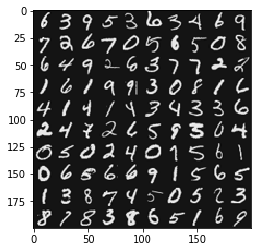

In [5]:
def displayData(X, index_list=[]):
    row, col = 10, 10
    h, w = 20, 20
    if len(index_list) == 0:
        index_list = sample(range(X.shape[0]), row * col)
        
    picture = np.zeros((row*h, col*w))
    i, j = 0, 0
    for index in index_list:
        if j == col:
            j = 0
            i += 1
        row_position = i * h
        col_position = j * w
        image = X[index].reshape(h, w).T
        #print(image.shape)
        #print(row_position, row_position + h, col_position, col_position + w)
        picture[row_position:row_position + h, col_position:col_position + w] = image
        j += 1
    
    plt.imshow(picture, cmap='gray')
    
displayData(X)

In [137]:
def feedForward(theta, feature):
    #print("feature:", feature.shape)
    #print("theta:")
    #for index, weight in enumerate(theta):
    #    print("\tindex", index, "-", weight.shape)
    
    layer_info = []
    a = feature
    
    for weight in theta:
        a = np.array(np.insert(a, 0, 1))
        z = weight.dot(a)
        z = z.reshape(len(z), 1)
        a = scipy.special.expit(z)
        layer_info.append((z,a))
    return a, layer_info

predict, layer_info = feedForward(theta, X[0])
for index, layer in enumerate(layer_info):
    z = layer[0]
    a = layer[1]
    print("z" + str(index+2) + ":", z.shape, 
          "a" + str(index+2) + ":",  a.shape)

z2: (25, 1) a2: (25, 1)
z3: (10, 1) a3: (10, 1)


In [275]:
def costFunction(theta, X, y, alpha):
    #print("X:", X.shape, "y:", y.shape, 'm:', len(y))
    #print("theta:")
    #for index, weight in enumerate(theta):
    #    print("\tindex", index, "-", weight.shape)
    
    answer_table = np.eye(10)
    
    total_cost = 0.
    m = len(y)
    for index in range(m):
        h, layer_info = feedForward(theta, X[index])
        answer = answer_table[y[index]-1].T
        #print(h.shape, answer.shape)
        left = -answer * np.log(h)
        right = (1-answer) * np.log(1-h)
        #print(left.shape)
        #print(right.shape)
        total_cost += left - right

    regular_term = 0.0
    
    for w in theta:
        regular_term += np.sum(w * w)
    regular_term *= alpha /(2*m)
    
    J = np.sum(total_cost)/m + regular_term
    return J    
print(costFunction(theta, X, y, 1.0))

0.38448779624289375


In [276]:
def sigmoid(z):
    return expit(z)

def sigmoidGradient(z):
    return sigmoid(z)*(1-sigmoid(z))

sigmoidGradient(0)

0.25

In [277]:
def randInitializeWeights(shape_list):
    theta = []
    epsilon_init = 0.12
    for shape in shape_list:
        theta.append(np.random.rand(shape[0], shape[1])*2*epsilon_init - epsilon_init)
    return theta
shape_list = []

input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10

shape_list.append((hidden_layer_size, input_layer_size + 1))
shape_list.append((output_layer_size, hidden_layer_size + 1))
    
initial_theta = randInitializeWeights(shape_list)
print(initial_theta[0].shape)
print(initial_theta[1].shape)

(25, 401)
(10, 26)


In [278]:
def backprop(theta, X, y):
    
    answer_table = np.eye(10)
    
    D_1 = np.zeros((hidden_layer_size, input_layer_size+1))
    D_2 = np.zeros((output_layer_size, hidden_layer_size+1))
    
    for index, feature in enumerate(X):
        predict, layer_info = feedForward(theta, feature)
        #print("predict", predict.shape)
        #for index, layer in enumerate(layer_info):
        #    z = layer[0]
        #    a = layer[1]
        #    print("z" + str(index+2) + ":", z.shape, 
        #          "a" + str(index+2) + ":",  a.shape)
        
        a1 = np.insert(feature, 0, 1).reshape(len(feature)+1, 1)
        a3 = layer_info[1][1]
        z2 = layer_info[0][0]
        a2 = np.insert(layer_info[0][1], 0, 1).reshape(hidden_layer_size+1, 1)
        
        answer = answer_table[:, y[index]-1].reshape(output_layer_size, 1)
        
        #print("for delte3", a3.shape, answer.shape)
        delta3 = a3 - answer
        #print("result delta3", delta3.shape)
        
        #theta_1.T * delta3 .* g'(z2)
        #print("for delta2", theta[1][:,1:].shape, delta3.shape)
        delta2 = theta[1][:,1:].T.dot(delta3) * sigmoidGradient(z2)
        #print("result delta2", delta2.shape)
    
        #print("for D_1", delta2.shape, a1.shape)
        #print(D_1.shape)       
        D_1 += delta2.dot(a1.T)
        #print("for D_2", delta3.shape, a2.shape)
        D_2 += delta3.dot(a2.T)
        #print(D_2.shape)
    D_1 /= len(y)
    D_2 /= len(y)
    return [D_1, D_2]
    
delta = backprop(initial_theta, X, y)

In [279]:
def flatten_theta(theta):
    flatten = np.array([])
    for w in theta:
        flatten = np.concatenate((flatten, w.flatten()))
        #print(len(w.flatten()))
    return flatten

def reshape_theta(flatten, shape_list):
    theta = []
    previous_pivot = 0
    for shape in shape_list:
        start = previous_pivot
        end = previous_pivot + shape[0] * shape[1]
        theta.append(flatten[start:end].reshape(shape[0], shape[1]))
        previous_pivot = end
    return theta

#validation
flatten = flatten_theta(initial_theta)
shape_list = []
shape_list.append([hidden_layer_size, input_layer_size+1])
shape_list.append([output_layer_size, hidden_layer_size+1])
reshaped = reshape_theta(flatten, shape_list)

print((reshaped[0] == initial_theta[0]).sum())
print((reshaped[1] == initial_theta[1]).sum())

10025
260


In [282]:
flatten = flatten_theta(initial_theta)
backprob_flatten = flatten_theta(delta)
for x in range(5):
    feature_index = sample(range(len(flatten)), 1)
    epsilon = np.zeros(len(flatten))
    epsilon[feature_index] = 1e-4
    low_feature = flatten + epsilon
    high_feature = flatten - epsilon
    #print(low_feature[feature_index])
    #print(high_feature[feature_index])
    
    low_cost = costFunction(reshape_theta(low_feature, shape_list), X, y, 0.0)
                           
    high_cost = costFunction(reshape_theta(high_feature, shape_list), X, y, 0.0)
    numerical_diff = (high_cost-low_cost)/float(2*1e4)
    
    print("numerical: ", numerical_diff, "backprob", backprob_flatten[feature_index])
    

numerical:  -8.496758852061248e-16 backprob [8.49700783e-08]
numerical:  -3.625543598673175e-11 backprob [0.00362554]
numerical:  1.7035262089848402e-16 backprob [-1.70342454e-08]
numerical:  -3.7700509381011215e-15 backprob [3.77000229e-07]
numerical:  2.0220339003174103e-11 backprob [-0.00202203]
